# Computer Vision - Semester 8, Spring 2021
## Laboratory Project 2: Optical Flow Estimation and Feature Extraction in Videos for Movement Recognition
### Part 1: Face and Hands Tracking with Lucas-Kanade Optical Flow Method
 Christos Dimopoulos (031 17 037)<br>
 Dimitris Dimos (031 17 165)

In [2]:
import importlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import skimage
from scipy.stats import multivariate_normal
from scipy.ndimage import label, generate_binary_structure, map_coordinates

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# just to center image depiction 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### 1.1 Ανίχνευση Δέρματος Προσώπου και Χεριών

In [4]:
# Read Skin Samples in RGB Format
skin_samplesRGB = scipy.io.loadmat('skinSamplesRGB.mat')['skinSamplesRGB']

Αρχικά, δημιουργούμε μια συνάρτηση που να  εκπαιδεύει μια Γκαουσσιανή πυκνότητα πιθανότητας πάνω στις εικόνες - δείγματα με ανθρώπινο δέρμα που εμπεριέχονται στο αρχείο 'skinSamplesRGB.mat'. Η συνάρτηση αυτή επιστρέφει το διάνυσμα μέσης τιμής μ (1x2) και τον πίνακα συνδιασποράς Σ (2x2) της Gaussian κατανομής.

In [5]:
"""
Function that return the mean value vector and covariance matrix after training on skin sample images

Usage:
mean, covariance = Gaussian_pdf(skin_samples)

Input:
(nxmx3) Array of Skin Samples in RGB format

Output:
mean: 1x2 vector of mean values of Gaussian PDF
covariance: 2x2 covariance matrix of Gaussian PDF
"""

def Gaussian_pdf(skin_samplesRGB):
    
    #convert RGB to YCbCr color space
    skin_samplesYCrCb = cv2.cvtColor(skin_samplesRGB, cv2.COLOR_RGB2YCrCb)
    
    # concatenate arrayes to one array of 3 channels - YCrCb
    skin_samplesYCrCb.reshape((-1,3))
    skin_samplesYCrCb = np.vstack(skin_samplesYCrCb)
    
    # Discard Luminance Channel of Y
    skin_samplesCrCb = skin_samplesYCrCb[:, 1:]
    
    mean_vector = np.mean(skin_samplesCrCb, axis=0)
    covariance_matrix = np.cov(skin_samplesCrCb[:,0],skin_samplesCrCb[:,1])
    return mean_vector, covariance_matrix

In [6]:
mean_CrCb, covariance_CrCb = Gaussian_pdf(skin_samplesRGB)
print(mean_CrCb)
print(covariance_CrCb)

[157.04601571 103.2704826 ]
[[ 44.19103128 -11.9310385 ]
 [-11.9310385   11.19574811]]


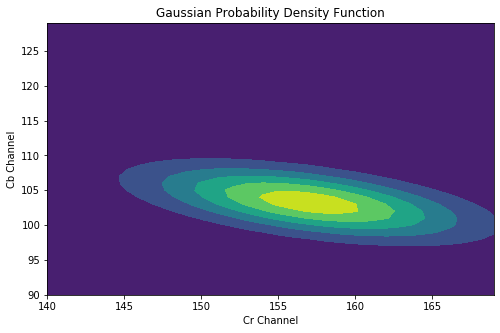

In [7]:
# Plot Probability Distribution of Multivariate Gaussian
x, y = np.mgrid[140:170:1, 90:130:1]
pos = np.dstack((x, y))
rv = multivariate_normal(mean_CrCb, covariance_CrCb)
rcParams['figure.figsize'] = [8,5]
plt.contourf(x, y, rv.pdf(pos))
plt.title('Gaussian Probability Density Function')
plt.xlabel('Cr Channel')
plt.ylabel('Cb Channel')
plt.show()

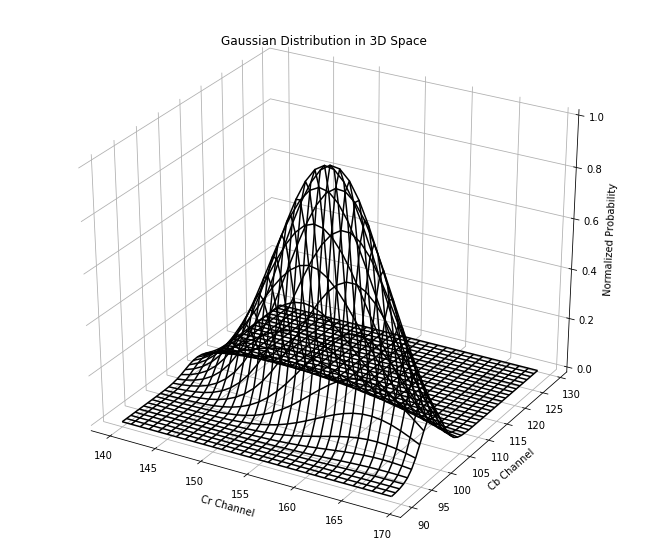

In [8]:
# Plot in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.plot_wireframe(x, y, rv.pdf(pos)/np.max(rv.pdf(pos)), color='black')#)cmap=cm.PuOr)
plt.title('Gaussian Distribution in 3D Space', y=1)
plt.xlabel('Cr Channel')
plt.ylabel('Cb Channel')
ax.set_zlabel('Normalized Probability')
plt.show()

Στη συνέχεια, εστιάζουμε στο πρώτο frame του βίντεο που χρεησιμοποιείται για ανίχνευση οπτικής ροής. Δημιουργούμε την δυαδική εικόνα πιθανότητας P(c = skin), όπου c = (x,y) pixel της εικόνας, επιλέγοντας ως κατώφλι 0.2 για την κανονικοποιημένη Γκαουσσιανή κατανομή που εκπαιδεύσαμε.

In [9]:
# Read 1st Frame
frame1_source = 'GreekSignLanguage/1.png'
frame1 = np.array(cv2.imread(frame1_source, 1))
frame1_ycbcr = cv2.cvtColor(frame1, cv2.COLOR_BGR2YCR_CB) # convert to YCbCr

cb_channel = frame1_ycbcr[:,:,1]
cr_channel = frame1_ycbcr[:,:,2]
X = np.array([cb_channel, cr_channel])

positions = np.dstack((cb_channel, cr_channel))
pdf = rv.pdf(positions)/np.max(rv.pdf(positions)) # Gaussian Distribution Function of First Frame

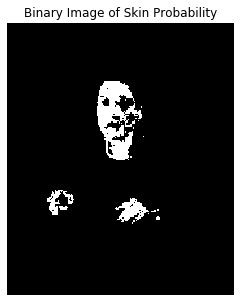

In [10]:
# Show Binary Image of Pr(c=skin)
threshold = 0.2
binary_skin = (pdf>threshold)*1
binary_skin = binary_skin.astype('uint8')
rcParams['figure.figsize'] = [5,5]
plt.imshow(binary_skin, cmap='gray')
plt.title('Binary Image of Skin Probability')
plt.axis('off')
plt.show()

Ακολούθως, εφαρμόζουμε στην δυαδική εικόνα μορφολογικούς τελεστές με την εξής σειρά: αρχικά ένα **opening** με πυρήνα μικρών διαστάσεων και στη συνέχεια ένα **closing** με πυρήνα μεγάλων διαστάσεων στο αποτέλεσμα.

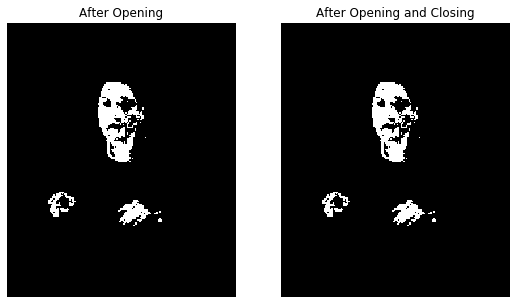

In [47]:
# Apply Morphological Filters
opening_kernel = np.ones((2,2),dtype=np.uint8)
closing_kernel = np.ones((25,25),dtype=np.uint8)

opening = cv2.morphologyEx(binary_skin, cv2.MORPH_OPEN, opening_kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, closing_kernel)

figure, axs = plt.subplots(1,2)
rcParams['figure.figsize'] = [9,9]
axs[0].imshow(opening, cmap='gray')
axs[0].set_title('After Opening')
axs[1].imshow(opening, cmap='gray')
axs[1].set_title('After Opening and Closing')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

Τέλος, προσδιορίζουμε τις τρεις βασικές συνεκτικές συνιστώσες δέρματος που εμπεριέχονται στην εικόνα και δημιουργούμε bounding boxes γύρω από αυτές.

In [12]:
s = generate_binary_structure(2,2) # 2x2 rectangular kernel
labeled_array, num_features = label(closing, structure=s)
print('Number of Discrete Components = ',num_features,'(Head, Right Hand, Left Hand)')

Number of Discrete Components =  3 (Head, Right Hand, Left Hand)


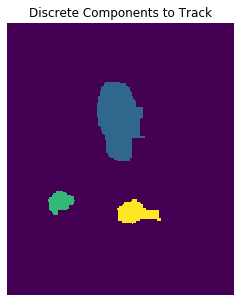

In [49]:
# Plot Discrete Components
rcParams['figure.figsize'] = [5,5]
plt.imshow(labeled_array)
plt.axis('off')
plt.title('Discrete Components to Track')
plt.show()

In [14]:
"""
Function that creates a rectangular bounding box around a component of value = val
Usage:
x, y, width, height = create_box(image, val)
Input:
image: image to create bounding boxes on
val: Value of Discrete component that the bounding box will surround
Output:
(x, y): coordinates of top-leftmost pixel of the bounding box
(width, height): dimensions of bounding box
"""
def create_box(image, val):
    # threshold
    thresh_binary = (image==val).astype('uint8')
    
    # get contours
    contours = cv2.findContours(thresh_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,width,height = cv2.boundingRect(cntr)
    return x, y, width, height

In [15]:
x, y, width, height = create_box(labeled_array, 1)
print('Head Component: x=',x,', y=',y,', Width=', width,', Height=', height)
x, y, width, height = create_box(labeled_array, 2)
print('Left Hand Component: x=',x,', y=',y,', Width=', width,', Height=', height)
x, y, width, height = create_box(labeled_array, 3)
print('Right Hand Component: x=',x,', y=',y,', Width=', width,', Height=', height)

Head Component: x= 139 , y= 91 , Width= 74 , Height= 122
Left Hand Component: x= 63 , y= 259 , Width= 42 , Height= 38
Right Hand Component: x= 169 , y= 271 , Width= 68 , Height= 40


Συνοψίζοντας, δημιουργούμε μια συνάρτηση που να πραγματοποιεί την παραπάνω διαδικασία συνολικά.

In [16]:
def fd(I, mu, cov):
    I_ycbcr = cv2.cvtColor(I, cv2.COLOR_BGR2YCR_CB) # convert to YCbCr

    cb_channel = I_ycbcr[:,:,1]
    cr_channel = I_ycbcr[:,:,2]
    X = np.array([cb_channel, cr_channel])
    
    # Create Binary Probability Image
    rv = multivariate_normal(mu, cov)
    positions = np.dstack((cb_channel, cr_channel))
    pdf = rv.pdf(positions)/np.max(rv.pdf(positions))
    threshold = 0.2
    binary_skin = (pdf>threshold)*1
    binary_skin = binary_skin.astype('uint8')
    
    # Apply Morphological Filters
    opening_kernel = np.ones((2,2),dtype=np.uint8)
    closing_kernel = np.ones((25,25),dtype=np.uint8)
    opening = cv2.morphologyEx(binary_skin, cv2.MORPH_OPEN, opening_kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, closing_kernel)
    
    # Create Bounding Boxes
    s = generate_binary_structure(2,2) # 2x2 rectangular kernel
    labeled_array, num_features = label(closing, structure=s)
    
    x, y, width, height = create_box(labeled_array, 1)
    head_box = {"x":x, "y":y, "width":width, "height":height}
    x, y, width, height = create_box(labeled_array, 2)
    lefthand_box = {"x":x, "y":y, "width":width, "height":height}
    x, y, width, height = create_box(labeled_array, 3)
    righthand_box = {"x":x, "y":y, "width":width, "height":height}
    
    return head_box, lefthand_box, righthand_box

### 1.2 Παρακολούθηση Προσώπου και Χεριών

#### 1.2.1 Υλοποίηση του Αλγόριθμου των Lucas-Kanade

In [17]:
# Lucas - Kanade Algorithm
def lk(I1, I2, features, rho, epsilon, dx0, dy0, converge=0.02):
    I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
    I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)
    # normalize
    I1 = I1/np.max(I1)
    I2 = I2/np.max(I2)

    max_iterations = 50 # till convergence
    # Create 2D Grid

    x0,y0 = np.meshgrid(np.arange(0,I1.shape[1]),np.arange(0, I1.shape[0]))
    # Equation 6: Partial Derivatives
    gradient = np.gradient(I1)
    A1, A2 = gradient[1], gradient[0]
    dx, dy = [], []
    
    # Define Gaussian Kernel to convolve with
    kernelSize = int (np.ceil(3 * rho)*2 + 1)
    G = cv2.getGaussianKernel(kernelSize, rho)
    G = G @ G.T
    """if features is None:
        return np.array([0]),np.array([0])"""
    for pixel in features:
        dx0, dy0 = 0,0
        x, y = int(pixel[0][1]), int(pixel[0][0])
        for i in range(max_iterations):
            I1s = map_coordinates(I1,[np.ravel(y0+dy0), np.ravel(x0+dx0)], order=1).reshape(I1.shape) #interpolate I1
            A1s = map_coordinates(A1,[np.ravel(y0+dy0), np.ravel(x0+dx0)], order=1).reshape(A1.shape)#interpolate A1
            A2s = map_coordinates(A2,[np.ravel(y0+dy0), np.ravel(x0+dx0)], order=1).reshape(A2.shape) #interpolate A2

            # Equation 7: E(x) = In(x) - In-1(x+di)
            E = I2 - I1s
            # Equation 5:

            # Define 1st Matrix
            a11 = cv2.filter2D(A1s**2, -1, G)[x,y] + epsilon
            a12 = cv2.filter2D(A1s*A2s, -1, G)[x,y]
            a21 = cv2.filter2D(A1s*A2s, -1, G)[x,y]
            a22 = cv2.filter2D(A2s**2, -1, G)[x,y] + epsilon

            determinant = a11*a22-a12*a21 # don't forget to invert matrix

            # Define 2nd Matrix
            b1 = cv2.filter2D(A1s*E, -1, G)[x,y]
            b2 = cv2.filter2D(A2s*E, -1, G)[x,y]

            u1 = (a22*b1 - a12*b2)/determinant
            u2 = (-a21*b1 + a11*b2)/determinant

            dx0 = dx0 + u1
            dy0 = dy0 + u2
            if (np.linalg.norm(u1)<converge and np.linalg.norm(u2)<converge):
                break
        dx.append(dx0)
        dy.append(dy0)
    
    return np.array(dx), np.array(dy)

In [18]:
# Shi - Tomasi Corner Detection
def shi_tomasi_feats(image, parameters, Harris):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
    corners = cv2.goodFeaturesToTrack(gray,**parameters, useHarrisDetector=Harris)
    return corners

In [19]:
# Read First Frame and Find its Bounding Boxes
I1 = np.array(cv2.imread('GreekSignLanguage/1.png', 1))
#head_dict, lefthand_dict, righthand_dict = fd(I1, mean_CrCb, covariance_CrCb)
head_dict = {'x':138, 'y':88, 'width':73, 'height':123}
lefthand_dict = {'x':47, 'y':243, 'width':71, 'height':66}
righthand_dict = {'x':162, 'y':264, 'width':83, 'height':48}


# Crop Image
head_box1 = I1[head_dict['y']:head_dict['y']+head_dict['height'], head_dict['x']:head_dict['x']+head_dict['width']]
lefthand_box1 = I1[lefthand_dict['y']:lefthand_dict['y']+lefthand_dict['height'], lefthand_dict['x']:lefthand_dict['x']+lefthand_dict['width']]
righthand_box1 = I1[righthand_dict['y']:righthand_dict['y']+righthand_dict['height'], righthand_dict['x']:righthand_dict['x']+righthand_dict['width']]

# Read Second Frame
I2 = np.array(cv2.imread('GreekSignLanguage/2.png', 1))

# Crop Image
head_box2 = I2[head_dict['y']:head_dict['y']+head_dict['height'], head_dict['x']:head_dict['x']+head_dict['width']]
lefthand_box2 = I2[lefthand_dict['y']:lefthand_dict['y']+lefthand_dict['height'], lefthand_dict['x']:lefthand_dict['x']+lefthand_dict['width']]
righthand_box2 = I2[righthand_dict['y']:righthand_dict['y']+righthand_dict['height'], righthand_dict['x']:righthand_dict['x']+righthand_dict['width']]

In [20]:
def plot_boxes(image, head_dict, lefthand_dict, righthand_dict, save=False, directory='./', name='image'):
    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    rcParams['figure.figsize'] = [6,6]
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Create Rectangle patches
    head_rect = plt.Rectangle((head_dict['x'],head_dict['y']), head_dict['width'], head_dict['height'],edgecolor='r', facecolor='none')
    left_rect = plt.Rectangle((lefthand_dict['x'],lefthand_dict['y']), lefthand_dict['width'], lefthand_dict['height'],edgecolor='c', facecolor='none')
    right_rect = plt.Rectangle((righthand_dict['x'],righthand_dict['y']), righthand_dict['width'], righthand_dict['height'],edgecolor='m', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(head_rect)
    ax.add_patch(left_rect)
    ax.add_patch(right_rect)
    plt.axis('off')
    plt.title('Bounding Boxes of Frame '+name)
    if save==True:
        title = directory + name + '.png'
        plt.savefig(title)
    plt.show()

In [41]:
def plot_optical_flow(features, dx, dy, frame, box, name, save=False, directory='./'):
    features = features.astype('int').reshape(features.shape[0], features.shape[2])
    rcParams['figure.figsize'] = [6,6]
    plt.quiver(features[:,0], features[:,1],-dx, -dy, angles='xy', scale=100)
    title = 'Frame '+str(frame)+': Optical Flow of '+box+'.'
    plt.title(title)
    if save==True:
        title = directory +'/'+ name + '.png'
        plt.savefig(title)
    plt.show()

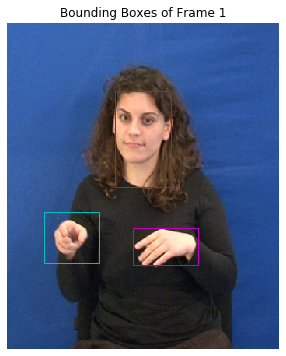

In [23]:
plot_boxes(I1, head_dict, lefthand_dict, righthand_dict, False ,directory='./motion_track/', name='1')

In [24]:
# Lucas-Kanade Parameters
dx0 = 0
dy0 = 0
rho = 8
epsilon = 0.01

In [25]:
# Shi-Tomasi Parameters
max_corners = 100
quality = 0.01
mindistance = 15
parameters = dict(maxCorners = max_corners, qualityLevel = quality, minDistance = mindistance)
parameters2 = dict(maxCorners = 200, qualityLevel = 0.01, minDistance = 5)

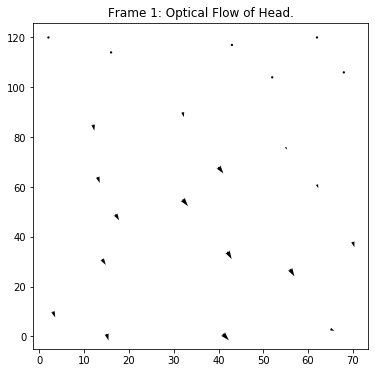

In [42]:
# Apply Lucas Kanade on Head Bounding Box
corners_head = shi_tomasi_feats(head_box2, parameters, False)

dx1, dy1 = lk(head_box1, head_box2, corners_head, rho, epsilon, 0,0)
plot_optical_flow(corners_head, dx1, dy1, frame='1', box='Head', name='1', save=False, directory='optical_flow/head')

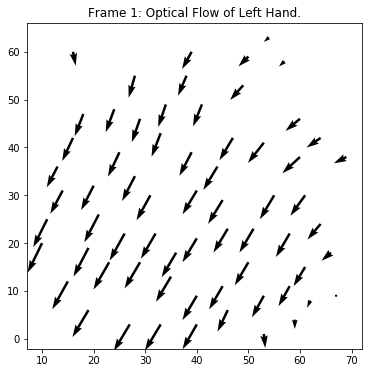

In [43]:
# Apply Lucas Kanade on Left Hand Bounding Box
corners_left = shi_tomasi_feats(lefthand_box2, parameters2, False)
dx2, dy2 = lk(lefthand_box1, lefthand_box2, corners_left, rho, epsilon, 0,0)
plot_optical_flow(corners_left, dx2, dy2, frame='1', box='Left Hand', name='1', save=False, directory='optical_flow/left_hand')

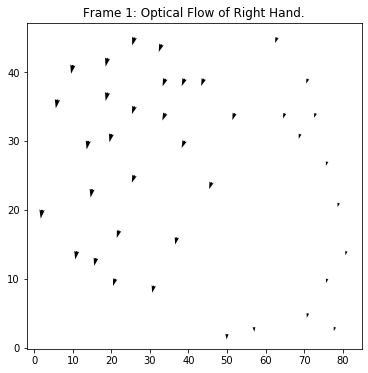

In [44]:
# Apply Lucas Kanade on Left Hand Bounding Box
corners_right = shi_tomasi_feats(righthand_box2, parameters2, False)
dx3, dy3 = lk(righthand_box1, righthand_box2, corners_right, rho, epsilon, 0,0)
plot_optical_flow(corners_right, dx3, dy3, frame='1', box='Right Hand', name='1', save=False, directory='optical_flow/right_hand')

### Πειραματισμός Παραμέτρων

Εστιάζουμε στο bounding box του αριστερού χεριού και υπολογίζουμε την οπτική ροή ανάμεσα στα πρώτα δύο frames, για διάφορες τιμές των παραμέτρων ε και ρ:

In [29]:
epsilons = [0.01, 0.05, 0.07, 0.1]
rhos = [1, 3, 5, 10]

In [30]:
experiments = [] # total of 16 combinations
for e in epsilons:
    for r in rhos:
        dx, dy = lk(lefthand_box1, lefthand_box2, corners_left, r, e, 0,0)
        experiments.append((dx, dy))

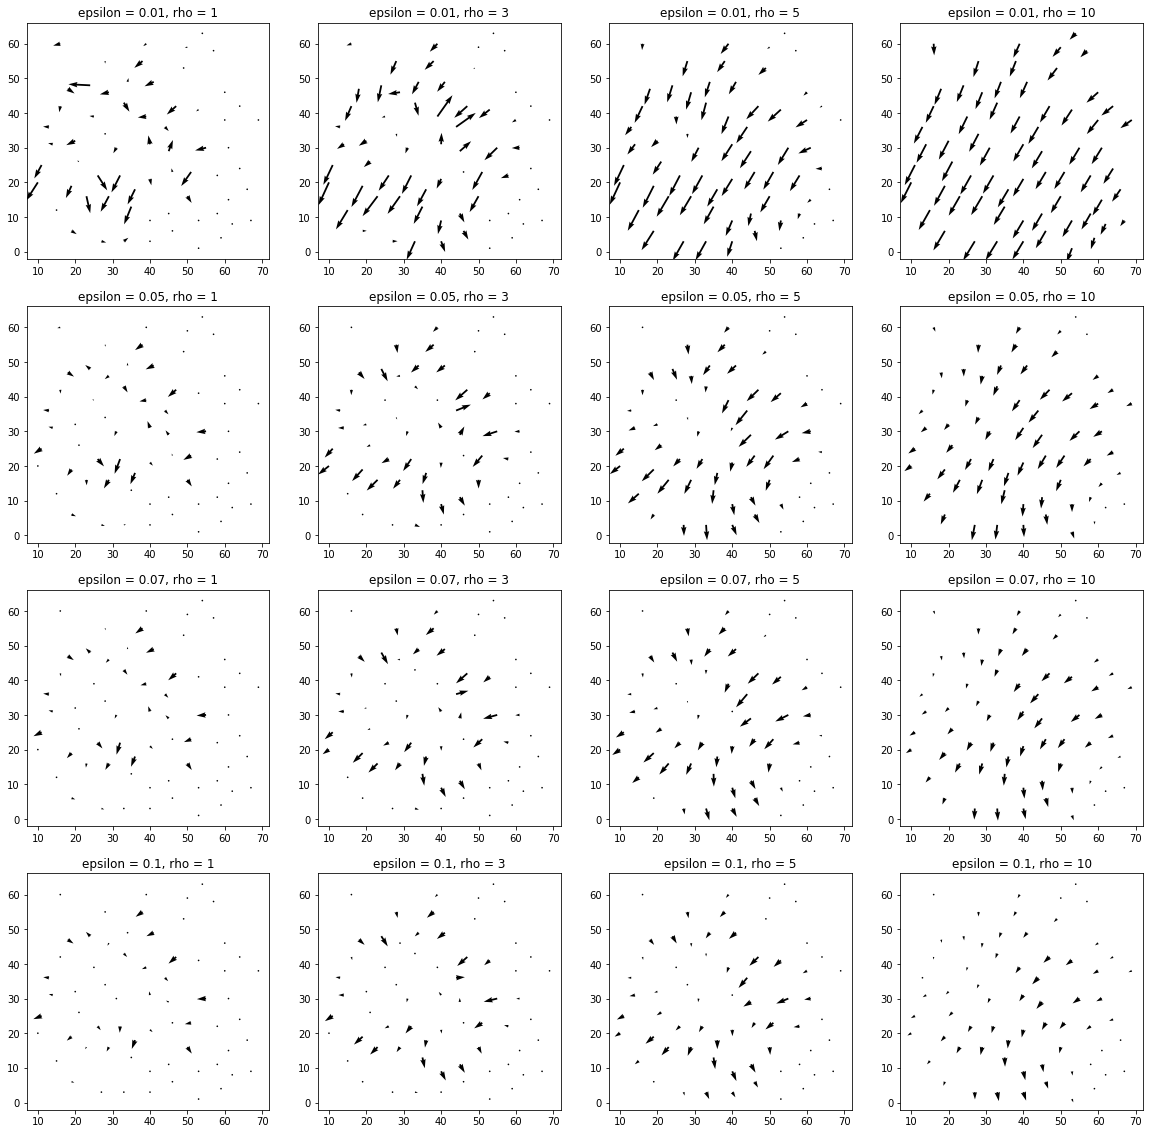

In [40]:
fig, axs = plt.subplots(4, 4)
features = corners_left.astype('int').reshape(corners_left.shape[0], corners_left.shape[2])
counter = 0
rcParams['figure.figsize'] = [20, 20]
for i in range(4):
    for j in range(4):
        axs[i,j].quiver(features[:,0], features[:,1],-experiments[counter][0], -experiments[counter][1], angles='xy', scale=100)
        title = "epsilon = "+str(epsilons[i])+", rho = "+str(rhos[j])
        axs[i,j].set_title(title)
        counter +=1

#### 1.2.2 Υπολογισμός της Μετατόπισης των Παραθύρων από τα Διανύσματα Οπτικής Ροής

In [115]:
# Function that returns mean speed vectors dx, dy of the bounding box
def displ(dx, dy, threshold=0.5):
    energy = dx**2+dy**2
    mask = (energy > threshold).astype('int32')
    
    if np.sum(mask)==0:
        return 0,0
    
    dx_mean = np.sum(dx*mask)/np.sum(mask)
    dy_mean = np.sum(dy*mask)/np.sum(mask)

    return int(np.round(dx_mean)), int(np.round(dy_mean))

Πειραματιζόμαστε για διαφορετικές τιμές της παραμέτρου threshold, πάνω στην οπτική ροή των δύο πρώτων frames για το bounding box του αριστερού χεριού.

In [110]:
epsilons = [0.01, 0.05]
rhos = [1, 3, 5]
experiments = [] # total of 6 combinations
for e in epsilons:
    for r in rhos:
        dx, dy = lk(lefthand_box1, lefthand_box2, corners_left, r, e, 0,0)
        experiments.append((dx, dy))

In [126]:
# Print Total Displacements for different Thresholds
thresholds = [0.001, 0.2, 0.5, 0.75]
counter = 0
for k in range(4):
    for i in range(2):
        for j in range(3):
            dispx, dispy = displ(-experiments[counter][0], -experiments[counter][1], threshold=thresholds[k])
            print('epsilon = '+str(epsilons[i])+", rho = "+str(rhos[j])+", Threshold = "+str(thresholds[k])+": dx = "+str(dispx)+", dy = "+str(dispy) )
            counter=+1
    print()

epsilon = 0.01, rho = 1, Threshold = 0.001: dx = -1, dy = -2
epsilon = 0.01, rho = 3, Threshold = 0.001: dx = -2, dy = -3
epsilon = 0.01, rho = 5, Threshold = 0.001: dx = -2, dy = -3
epsilon = 0.05, rho = 1, Threshold = 0.001: dx = -2, dy = -3
epsilon = 0.05, rho = 3, Threshold = 0.001: dx = -2, dy = -3
epsilon = 0.05, rho = 5, Threshold = 0.001: dx = -2, dy = -3

epsilon = 0.01, rho = 1, Threshold = 0.2: dx = -2, dy = -3
epsilon = 0.01, rho = 3, Threshold = 0.2: dx = -2, dy = -3
epsilon = 0.01, rho = 5, Threshold = 0.2: dx = -2, dy = -3
epsilon = 0.05, rho = 1, Threshold = 0.2: dx = -2, dy = -3
epsilon = 0.05, rho = 3, Threshold = 0.2: dx = -2, dy = -3
epsilon = 0.05, rho = 5, Threshold = 0.2: dx = -2, dy = -3

epsilon = 0.01, rho = 1, Threshold = 0.5: dx = -2, dy = -4
epsilon = 0.01, rho = 3, Threshold = 0.5: dx = -2, dy = -4
epsilon = 0.01, rho = 5, Threshold = 0.5: dx = -2, dy = -4
epsilon = 0.05, rho = 1, Threshold = 0.5: dx = -2, dy = -4
epsilon = 0.05, rho = 3, Threshold = 0.5: 

Στη συνέχεια, δοκιμάζουμε ως διαφορετικό (και πιο αφελές) κριτήριο υπολογισμού της μετατόπισης από τα διανύσματα οπτικής ροής, απλώς τον μέσο όρο των μετατοπίσεων χωρίς κάποια κατωφλιοποίηση:

In [45]:
# Print Total Displacements for different Thresholds
counter = 0
for k in range(4):
    for i in range(2):
        for j in range(3):
            dispx, dispy = np.round(np.mean(-experiments[counter][0])), np.round(np.mean(-experiments[counter][1]))
            print('epsilon = '+str(epsilons[i])+", rho = "+str(rhos[j])+": dx = "+str(dispx)+", dy = "+str(dispy) )
            counter=+1
    print()

epsilon = 0.01, rho = 1: dx = -1.0, dy = -1.0
epsilon = 0.01, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 5: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 1: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 5: dx = -1.0, dy = -3.0

epsilon = 0.01, rho = 1: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 5: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 1: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 5: dx = -1.0, dy = -3.0

epsilon = 0.01, rho = 1: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 5: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 1: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 5: dx = -1.0, dy = -3.0

epsilon = 0.01, rho = 1: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 3: dx = -1.0, dy = -3.0
epsilon = 0.01, rho = 5: dx = -1.0, dy = -3.0
epsilon = 0.05, rho = 1: dx = -

Στη συνέχεια, δοκιμάζουμε τη συνάρτηση Lucas-Kanade πάνω στην ανίχνευση κίνησης για όλα τα frames:

In [40]:
###### Track Motion in all Frames #######

def motion_track(head_dict, lefthand_dict, righthand_dict, rho, epsilon, savedir, multiscale = False, scale=0):
    I1 = np.array(cv2.imread('GreekSignLanguage/1.png', 1))
    # Crop Bounding Boxes
    faceOld = I1[head_dict['y']:head_dict['y']+head_dict['height'], head_dict['x']:head_dict['x']+head_dict['width']]
    leftOld = I1[lefthand_dict['y']:lefthand_dict['y']+lefthand_dict['height'], lefthand_dict['x']:lefthand_dict['x']+lefthand_dict['width']]
    rightOld = I1[righthand_dict['y']:righthand_dict['y']+righthand_dict['height'], righthand_dict['x']:righthand_dict['x']+righthand_dict['width']]
    plot_boxes(I1, head_dict, lefthand_dict, righthand_dict, True ,directory=savedir, name='1')
    
    noofimages=67
    for i in range(2,noofimages):
        path = 'GreekSignLanguage/'+str(i)+'.png'
        newimage = np.array(cv2.imread(path, 1))
        # Crop Bounding Boxes
        faceNew = newimage[head_dict['y']:head_dict['y']+head_dict['height'], head_dict['x']:head_dict['x']+head_dict['width']]
        leftNew = newimage[lefthand_dict['y']:lefthand_dict['y']+lefthand_dict['height'], lefthand_dict['x']:lefthand_dict['x']+lefthand_dict['width']]
        rightNew = newimage[righthand_dict['y']:righthand_dict['y']+righthand_dict['height'], righthand_dict['x']:righthand_dict['x']+righthand_dict['width']]

        # Extract Features with Shi-Tomasi Detector
        corners_head = shi_tomasi_feats(faceOld, parameters, False)
        corners_left = shi_tomasi_feats(leftOld, parameters, False)
        corners_right = shi_tomasi_feats(rightOld, parameters, False)

        # Apply Lucas-Kanade Algorithm
        if multiscale==True:
            dx1, dy1 = multi_lk(faceOld, faceNew, corners_head, rho, epsilon, scale, parameters)
            dx2, dy2 = multi_lk(leftOld, leftNew, corners_left, rho, epsilon, scale, parameters)
            dx3, dy3 = multi_lk(rightOld, rightNew, corners_right, rho, epsilon, scale, parameters)
        else:
            dx1, dy1 = lk(faceOld, faceNew, corners_head, rho, epsilon, 0, 0)
            dx2, dy2 = lk(leftOld, leftNew, corners_left, rho, epsilon, 0, 0)
            dx3, dy3 = lk(rightOld, rightNew, corners_right, rho, epsilon, 0, 0)

        # find speed Vector for each Bounding Box
        displ_x1, displ_y1 = displ(dx1, dy1)
        displ_x2, displ_y2 = displ(dx2, dy2)
        displ_x3, displ_y3 = displ(dx3, dy3)

        # Update Positions of bounding Boxes
        head_dict['x'] = int(head_dict['x'] - displ_x1)
        head_dict['y'] = int(head_dict['y'] - displ_y1)

        lefthand_dict['x'] = int(lefthand_dict['x'] - displ_x2)
        lefthand_dict['y'] = int(lefthand_dict['y'] - displ_y2)

        righthand_dict['x'] = int(righthand_dict['x'] - displ_x3)
        righthand_dict['y'] = int(righthand_dict['y'] - displ_y3)

        plot_boxes(newimage, head_dict, lefthand_dict, righthand_dict, save=True, directory=savedir, name=str(i))
        #plot_optical_flow(corners_head, dx1, dy1, frame=str(i), box='Head', name=str(i), save=True, directory='optical_flow/head')
        #plot_optical_flow(corners_left, dx2, dy2, frame=str(i), box='Left Hand', name=str(i), save=True, directory='optical_flow/left_hand')
        #plot_optical_flow(corners_right, dx3, dy3, frame=str(i), box='Right Hand', name=str(i), save=True, directory='optical_flow/right_hand')

        # Update for the next image-frame
        faceOld = np.array(faceNew)
        leftOld = np.array(leftNew)
        rightOld = np.array(rightNew)

In [ ]:
# Use given Values
head_dict = {'x':138, 'y':88, 'width':73, 'height':123}
lefthand_dict = {'x':47, 'y':243, 'width':71, 'height':66}
righthand_dict = {'x':162, 'y':264, 'width':83, 'height':48}

motion_track(head_dict, lefthand_dict, righthand_dict, rho, epsilon, savedir = './motion_track/', multiscale = False, scale=0)

#### 1.2.3 Πολυ-Κλιμακωτός Υπολογισμός Οπτικής Ροής

In [138]:
# Function that implements Multiscale Lucas-Kanade Algorithm
def multi_lk(I1, I2, features, rho, epsilon, scale, parameters):
    if scale == 0:
        dx, dy = lk(I1, I2,features, rho, epsilon, 0, 0)
        return dx, dy
    else:
        Gr = cv2.getGaussianKernel(3, rho) # 3-pixel Gaussian kernel
        # Lowpass Filter to avoid aliasing
        I1 = cv2.filter2D(I1, -1, Gr)
        I2 = cv2.filter2D(I2, -1, Gr)
        # Downsample
        faceOld = cv2.resize(I1, (I1.shape[1]//2, I1.shape[0]//2), interpolation=cv2.INTER_CUBIC)
        faceNew = cv2.resize(I2, (I2.shape[1]//2, I2.shape[0]//2), interpolation=cv2.INTER_CUBIC)
        # Extract Features on Lower Resolution
        #new_parameters = dict(maxCorners = parameters['maxCorners']+50, qualityLevel = parameters['qualityLevel']-0.001, minDistance = parameters['minDistance']-1)
        new_features = features//2 -1 #shi_tomasi_feats(faceNew, new_parameters, False)
        dx0, dy0 = multi_lk(faceOld, faceNew, new_features, rho, epsilon, scale-1, parameters)
        dx, dy = lk(I1, I2, features, rho, epsilon, 2*dx0, 2*dy0)
        return dx, dy

In [ ]:
# Use given Values
head_dict = {'x':138, 'y':88, 'width':73, 'height':123}
lefthand_dict = {'x':47, 'y':243, 'width':71, 'height':66}
righthand_dict = {'x':162, 'y':264, 'width':83, 'height':48}

motion_track(head_dict, lefthand_dict, righthand_dict, rho, epsilon, savedir = './multi_track/', multiscale = True, scale=4)

Πειραματιζόμαστε πάνω στον Πολυκλιμακωτό Αλγόριθμο για διαφορές τιμές κλίμακας. Εστιάζουμε στο bounding box του αριστερού χεριού για τα δύο πρώτα frames:

In [140]:
rhos = [1, 3, 5]
epsilon = 0.05
scales = [2, 3, 4]
experiments = []

In [141]:
for s in scales:
    for r in rhos:
        dx, dy = multi_lk(lefthand_box1, lefthand_box2, corners_left, r, epsilon, s, parameters)
        experiments.append((dx, dy))

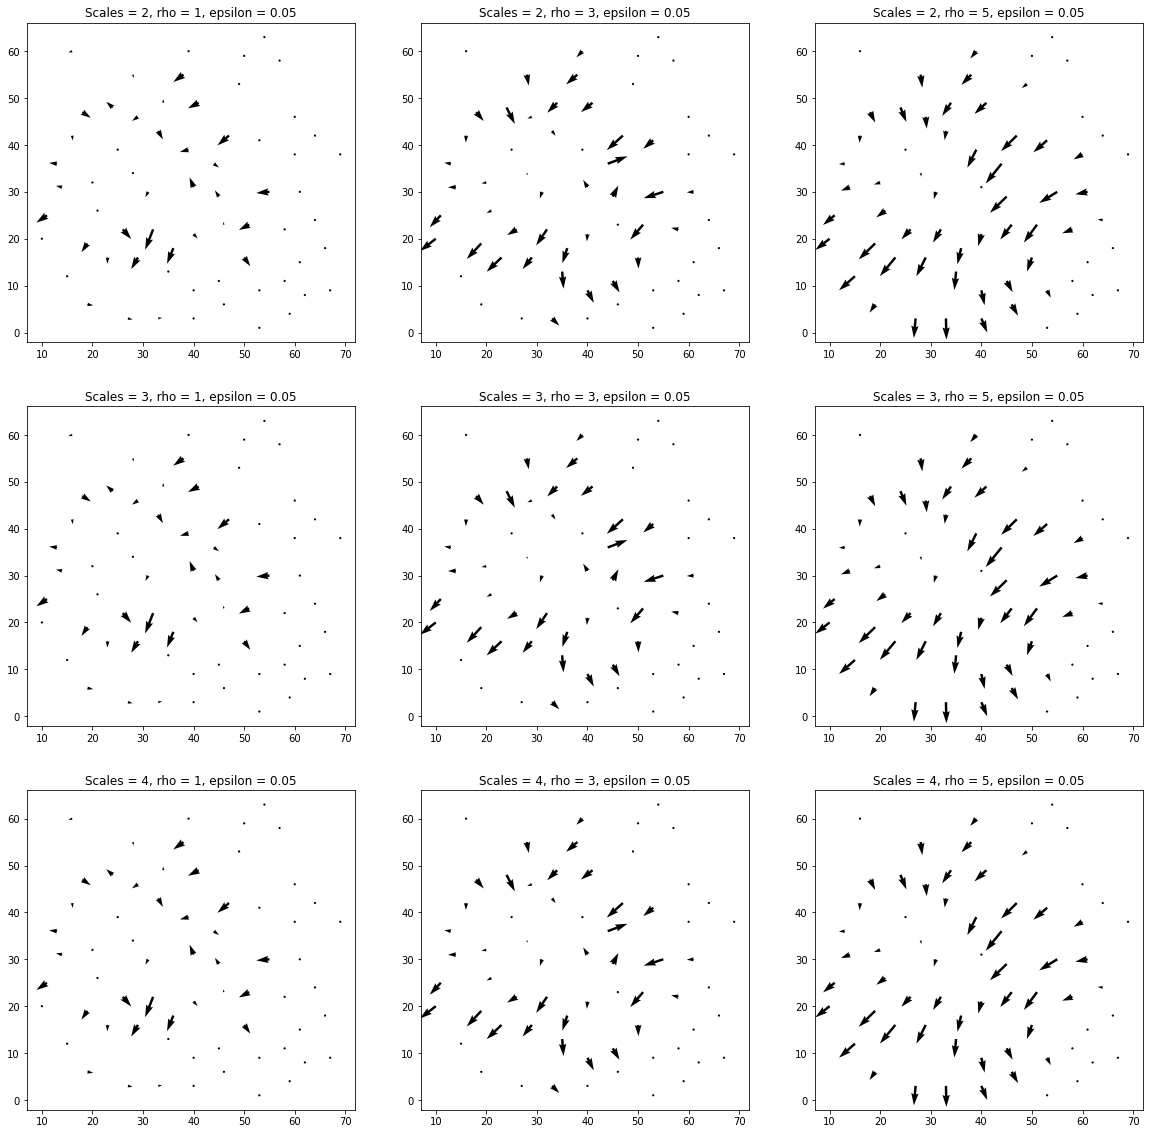

In [143]:
fig, axs = plt.subplots(3, 3)
features = corners_left.astype('int').reshape(corners_left.shape[0], corners_left.shape[2])
counter = 0
rcParams['figure.figsize'] = [20, 20]
for i in range(3):
    for j in range(3):
        axs[i,j].quiver(features[:,0], features[:,1],-experiments[counter][0], -experiments[counter][1], angles='xy', scale=100)
        title = "Scales = "+str(scales[i])+", rho = "+str(rhos[j])+", epsilon = 0.05"
        axs[i,j].set_title(title)
        counter +=1